<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Ensemble Learning: Majority Vote</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>🧠 Algorithm Intuition:</font></h3>

<ul>
    <li><i>Ensemble learning</i> is a collection of techniques that rest on the principle of combining the results of multiple "base learners" to yield a model success rate that exceeds that of any individual base learner.</li>
    <li>Combining results of multiple models this way is explained by probability theory. Whether or not a base learner correctly classifies a sample's label can be set up as a Bernoulli distribution. As there are multiple base learners in the ensemble, each one can be seen as a repeat of the same experiment, allowing the outcome to move from Bernoulli to a Binomial distribution. Hense, we can model the outcome of a random variate X (the number of times across all base learners that the label is predicted correctly) as approximately binomial (X ~ B(n, p)), where n is the number of trials (base learners) and p is the chance of the "positive" or "relevant" outcome for each one (accuracy).</i>
    <li>To calculate probabilities of binomial outcomes, we construct the related PDF, given by the below formula when X is replaced by k: </i>


<ul>

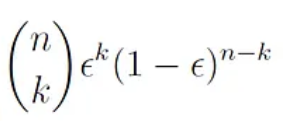

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<ul>
    <li>The PDF for X is plotted below for the case where 25 base learners with 75% accuracy each. The expected value of X is 19 base learners correctly classifying the sample and 6 incorrectly classifying. In the case of majority voting, half of the base learners or more must predict correctly, giving 25 / 2 = 12.5 = X must be at least 13.</i>
    <li>The summed probability P(13 ≤ X ≤ 25) = 0.9966.</li>
    <li>Viewed from another perspective, we can show it in terms of error rate (all same except p = 0.25). The below formula shows the calculation with a result of 0.0034.</i>
<ul>

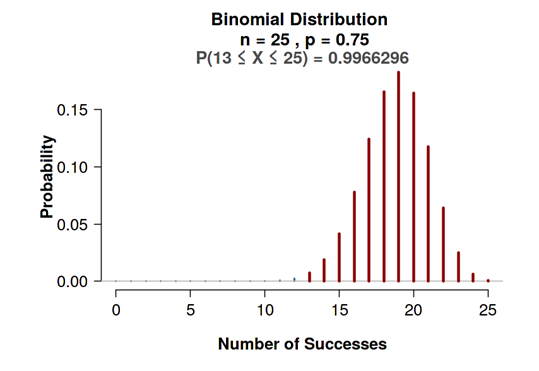

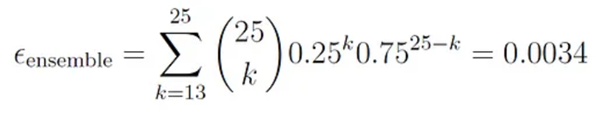

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>Assumptions</font></h3>

<ul>
    <li>The base classifiers should be independent of each other. If they're fully correlated (i.e. every learner predicts the same samples correctly and incorrectly), aggregation won't produce any improvement in outcome. In practice, it is difficult to ensure total independence between base learners. However, practice has shown that even when the classifiers are partially correlated, the ensemble can still perform better than any one of them.</li>
    <li>Each base classifier should an accuracy rate of less more than 50%, i.e., better than random guessing. A model that performs only slightly better is called a weak learner. As shown, an ensemble of many weak learners can become a strong learner.</li>
<ul>

*Import Libraries*

In [129]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import VotingClassifier


# import others
import os
import pickle
import warnings

In [130]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


*Approach*
1. Load data
2. Split data
3. Load best pipelines of all single algorithms
4. Create VotingClassifier object
5. Create and evaluate cross_val_score on all pipelines and on VotingClassifier
11. Plot classification_report and confusion_matrix

*Import data from initial EDA*

In [131]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [132]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
display(settings.examine_values(y_train).loc["Sleep Disorder",:])
display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

Unique Values    [2, 1, 0]
Name: Sleep Disorder, dtype: object

Unique Values    [2, 1, 0]
Name: Sleep Disorder, dtype: object

*Load base learners*

In [133]:
model_mlr = settings.get_saved_pipeline("best_multinomial_logistic_regression_pipeline.pkl")
model_nb = settings.get_saved_pipeline("best_naive_bayes_classification_pipeline.pkl")
model_knn = settings.get_saved_pipeline("best_knn_classification_pipeline.pkl")
model_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")

In [134]:
names = ['Logistic Regression']
pipelines = [model_mlr]

for pipeline, name in zip(pipelines, names):
    pipeline.fit(X_train, y_train)
    train_acc = pipeline.score(X_train, y_train)
    print(f'{name} Train Accuracy:', settings.score_formatter(train_acc, 3))

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv)

    # Calculate mean and standard deviation of cross-validation train scores
    mean_train_cv = np.mean(cv_scores)
    std_train_cv = np.std(cv_scores)
    print(f'{name} Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
            "( +-", settings.score_formatter(std_train_cv, 3), ")")

Logistic Regression Train Accuracy: 91.200 %
Logistic Regression Mean CV Train Accuracy: 90.4400 % ( +- 4.100 % )


In [136]:
names = ['NB']
pipelines = [model_nb]

for pipeline, name in zip(pipelines, names):
    pipeline.fit(X_train, y_train)
    train_acc = pipeline.score(X_train, y_train)
    print(f'{name} Train Accuracy:', settings.score_formatter(train_acc, 3))

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv)

    # Calculate mean and standard deviation of cross-validation train scores
    mean_train_cv = np.mean(cv_scores)
    std_train_cv = np.std(cv_scores)
    print(f'{name} Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
            "( +-", settings.score_formatter(std_train_cv, 3), ")")

NB Train Accuracy: 89.700 %
NB Mean CV Train Accuracy: 88.5200 % ( +- 3.800 % )


In [138]:
names = ['KNN']
pipelines = [model_knn]

for pipeline, name in zip(pipelines, names):
    pipeline.fit(X_train, y_train)
    train_acc = pipeline.score(X_train, y_train)
    print(f'{name} Train Accuracy:', settings.score_formatter(train_acc, 3))

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv)

    # Calculate mean and standard deviation of cross-validation train scores
    mean_train_cv = np.mean(cv_scores)
    std_train_cv = np.std(cv_scores)
    print(f'{name} Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
            "( +-", settings.score_formatter(std_train_cv, 3), ")")

KNN Train Accuracy: 89.700 %
KNN Mean CV Train Accuracy: 87.5000 % ( +- 4.300 % )


In [141]:
names = ['Decision Tree']
pipelines = [model_dt]

for pipeline, name in zip(pipelines, names):
    pipeline.fit(X_train, y_train)
    train_acc = pipeline.score(X_train, y_train)
    print(f'{name} Train Accuracy:', settings.score_formatter(train_acc, 3))

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv)

    # Calculate mean and standard deviation of cross-validation train scores
    mean_train_cv = np.mean(cv_scores)
    std_train_cv = np.std(cv_scores)
    print(f'{name} Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
            "( +-", settings.score_formatter(std_train_cv, 3), ")")

Decision Tree Train Accuracy: 90.400 %
Decision Tree Mean CV Train Accuracy: 89.4200 % ( +- 3.300 % )


*Instantiate ensemble* 

In [143]:
model_ensemble = VotingClassifier([('model_mlr', model_mlr), ('model_nb', model_nb), ('model_knn', model_knn), ('model_dt', model_dt)], 
                            voting='hard')

In [149]:
names = ['Logistic Regression', 'Naive Bayes', 'KNN', 'Decision Tree', 'Majority Vote']
pipelines = [model_mlr, model_nb, model_knn, model_dt, model_ensemble]
cv_means = []
cv_stds = []

for pipeline, name in zip(pipelines, names):
    pipeline.fit(X_train, y_train)
    train_acc = pipeline.score(X_train, y_train)
    print(f'{name} Train Accuracy:', settings.score_formatter(train_acc, 3))

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv)

    # Calculate mean and standard deviation of cross-validation train scores
    mean_train_cv = np.mean(cv_scores)
    cv_means.append(mean_train_cv)
    std_train_cv = np.std(cv_scores)
    cv_stds.append(std_train_cv)
    print(f'{name} Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
            "( +-", settings.score_formatter(std_train_cv, 3), ")\n *******************")

Logistic Regression Train Accuracy: 91.200 %
Logistic Regression Mean CV Train Accuracy: 90.4400 % ( +- 4.100 % )
 *******************
Naive Bayes Train Accuracy: 89.700 %
Naive Bayes Mean CV Train Accuracy: 88.5200 % ( +- 3.800 % )
 *******************
KNN Train Accuracy: 89.700 %
KNN Mean CV Train Accuracy: 87.5000 % ( +- 4.300 % )
 *******************
Decision Tree Train Accuracy: 90.400 %
Decision Tree Mean CV Train Accuracy: 89.4200 % ( +- 3.300 % )
 *******************
Majority Vote Train Accuracy: 90.800 %
Majority Vote Mean CV Train Accuracy: 90.3100 % ( +- 4.000 % )
 *******************


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li></li>
</ul>
</div>


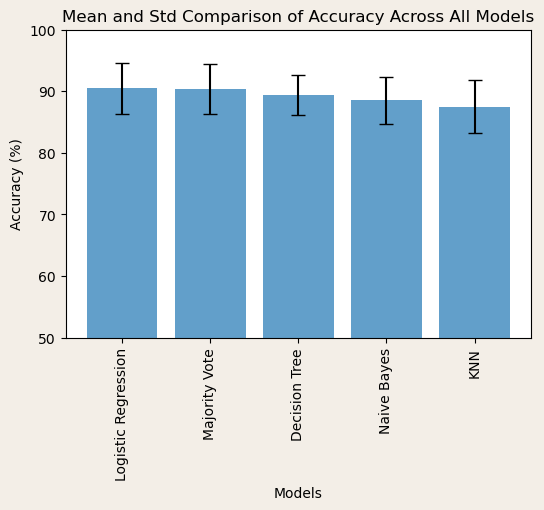

In [169]:
# Sort names and cv_means together based on cv_means values
sorted_indices = np.argsort(cv_means)[::-1]  # Get indices in descending order
sorted_names = [names[i] for i in sorted_indices]
sorted_cv_means = [cv_means[i] for i in sorted_indices]
sorted_names = [names[i] for i in sorted_indices]
sorted_stds = [cv_stds[i] for i in sorted_indices]


# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
plt.bar(sorted_names, np.array(sorted_cv_means)*100, yerr=np.array(sorted_stds)*100, capsize=5, align='center', alpha=0.7)

# Add plot details
ax.set_ylim(50, 100)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Mean and Std Comparison of Accuracy Across All Models')
plt.tick_params(axis='x', rotation=90)
plt.show()


*Examining the predictions*

Test Accuracy: 93.8100 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.92      0.86        24
           2       0.95      0.83      0.88        23

    accuracy                           0.94       113
   macro avg       0.92      0.91      0.91       113
weighted avg       0.94      0.94      0.94       113



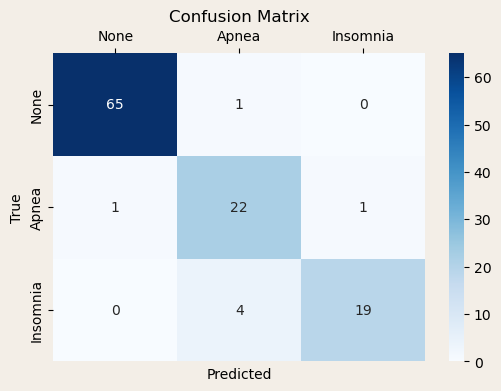

In [189]:
# Print test accuracy
model_ensemble.fit(X_train, y_train)
print("Test Accuracy:", settings.score_formatter(model_ensemble.score(X_test, y_test), 4))

# Generate prediction and show classification report
y_pred = model_ensemble.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Confusion matrix is very similar to the individual base learners</li>
</ul>
</div>


In [192]:
# Create dataframe: columns = models and rows = their predictions for each test sample
pred_dict = {}

for pipeline, name in zip(pipelines, names):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    pred_dict[name] = y_pred

prediction_df = pd.DataFrame(pred_dict)

In [186]:
final_df = pd.concat([pd.DataFrame(y_test, columns=["True"]), prediction_df], axis=1)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 To do:</font></h3>

<ul>
    <li>Find the indicies of the records incorrectly classified by each model.</li>
    <li>Per pair, calculate number of shared indicies and present proportion.</li>
    <li>High percentages show high agreement in their incorrect predictions (i.e. when one model makes a mistake, the other one does too</li>

</ul>
</div>
